# Предсказание спроса

В задании нужно было оценить спрос на товар за неделю, знаю спрос на различные товары за предыдущие периоды времени. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn import model_selection, preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("train.tsv")
test = pd.read_csv("test.tsv")
sample_submission = pd.read_csv("sample_submission.tsv")

In [3]:
# для проведения кросс-валидации
def smape(model, X, y):
    x = model.predict(X)
    return np.mean( abs(x-y) / (abs(x) + abs(y)) * 2 )

Итак, посмотрим на представленные данные - видно, что все $f_i$ похожи, посмотрим на зависимости некоторых из них (для остальных признаков нет ничего интересного в зависимостях, поэтому я не буду их приводить, чтобы не загромождать рисунки)

In [50]:
train.head()

,Num,y,year,week,shift,item_id,f1,f2,f3,f4,...,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60
0,0,123438,2012,52,1,20442076,4915.0,38056.0,40185.0,45733.0,...,39423.0,41765.0,52590.0,31452.0,44420.0,41865.0,52705.0,36102.0,44163.0,45239.0
1,1,58410,2012,52,1,20441997,2230.0,18817.0,20110.0,26368.0,...,22830.0,25230.0,27850.0,21390.0,27090.0,23170.0,29705.0,19140.0,22055.0,23200.0
2,2,163930,2012,52,1,20441990,5695.0,47480.0,47619.0,89708.0,...,14930.0,44290.0,46412.0,29320.0,21140.0,28406.0,65056.0,31886.0,48750.0,36520.0
3,3,53902,2012,52,1,20441989,1995.0,17146.0,20066.0,27070.0,...,15120.0,12480.0,19780.0,7990.0,8230.0,10650.0,21920.0,13040.0,9780.0,9630.0
4,4,105970,2012,52,1,20441988,6515.0,49262.0,50045.0,95167.0,...,18872.0,19328.0,37168.0,13570.0,19760.0,20208.0,34745.0,18442.0,24700.0,21793.0


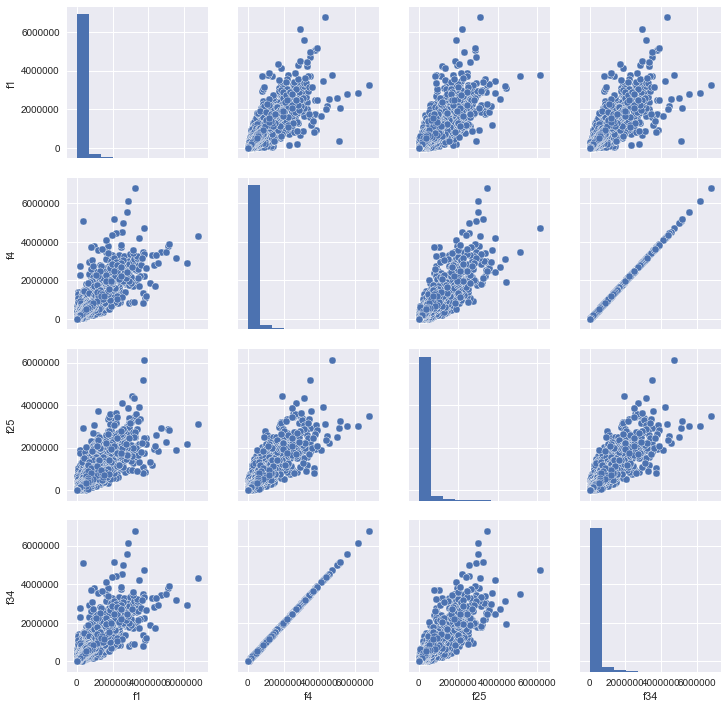

CPU times: user 12.7 s, sys: 408 ms, total: 13.1 s
Wall time: 13.4 s


In [19]:
%%time
plt.figure()
g = sns.pairplot(train[['f1','f4', 'f25', 'f34']])
plt.show()

Хм... но 4 и 34 признаки же совпадают... пахнет копипастом, как будто первые 30 признаков просто повторены 2 раза. давайте убедимся в этом. Посмотрим на корреляции

In [17]:
corr = train.corr()
corr

,Num,y,year,week,shift,item_id,f1,f2,f3,f4,...,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60
Num,1.000000,-0.009548,0.866658,0.429116,-0.010393,0.081876,-0.022025,-0.027451,-0.027193,-0.026814,...,-0.005997,-0.007323,-0.008821,-0.006485,-0.009270,-0.010627,-0.011496,-0.008580,-0.009177,-0.009994
y,-0.009548,1.000000,-0.027229,0.030007,-0.001167,-0.063221,0.892962,0.900556,0.888600,0.880223,...,0.907419,0.919785,0.930984,0.930706,0.918709,0.922795,0.938787,0.940542,0.929594,0.923167
year,0.866658,-0.027229,1.000000,-0.077971,0.014922,0.068177,-0.006884,-0.012877,-0.012669,-0.012803,...,-0.012790,-0.013917,-0.017406,-0.014016,-0.015069,-0.014998,-0.017410,-0.013622,-0.012500,-0.013578
week,0.429116,0.030007,-0.077971,1.000000,-0.000227,0.040956,-0.031504,-0.031330,-0.031149,-0.030121,...,0.011045,0.010441,0.013731,0.012169,0.008520,0.005684,0.008346,0.007264,0.004121,0.004466
shift,-0.010393,-0.001167,0.014922,-0.000227,1.000000,0.001012,0.000052,-0.000250,-0.000148,0.000036,...,0.000513,0.001036,0.000682,0.000506,0.000532,0.000793,0.000729,0.000068,-0.000356,0.001156
item_id,0.081876,-0.063221,0.068177,0.040956,0.001012,1.000000,-0.083112,-0.083075,-0.082570,-0.081968,...,-0.072016,-0.071238,-0.070500,-0.069713,-0.069057,-0.068268,-0.067456,-0.066522,-0.065631,-0.064746
f1,-0.022025,0.892962,-0.006884,-0.031504,0.000052,-0.083112,1.000000,0.912879,0.889924,0.891647,...,0.880752,0.903257,0.921423,0.885321,0.874428,0.886053,0.922908,0.887523,0.865053,0.870963
f2,-0.027451,0.900556,-0.012877,-0.031330,-0.000250,-0.083075,0.912879,1.000000,0.917430,0.895117,...,0.885197,0.884507,0.908155,0.933120,0.887709,0.878607,0.891671,0.935384,0.891558,0.869151
f3,-0.027193,0.888600,-0.012669,-0.031149,-0.000148,-0.082570,0.889924,0.917430,1.000000,0.917251,...,0.919224,0.884349,0.883490,0.909112,0.933104,0.887056,0.877827,0.892808,0.935120,0.890207
f4,-0.026814,0.880223,-0.012803,-0.030121,0.000036,-0.081968,0.891647,0.895117,0.917251,1.000000,...,0.931211,0.918592,0.883210,0.883549,0.909306,0.932652,0.886177,0.878041,0.892375,0.933938


И теперь посчитаем, у кого корреляции = 1

In [21]:
correlate = []
for i in train.corr():
    for j, k in enumerate(train.corr()[i]):
        if (k ==1.0) and (str(i) != train.columns[j]):
            correlate += [[i, train.columns[j]]]
correlate

[['f1', 'f31'],
 ['f2', 'f32'],
 ['f3', 'f33'],
 ['f4', 'f34'],
 ['f5', 'f35'],
 ['f6', 'f36'],
 ['f7', 'f37'],
 ['f8', 'f38'],
 ['f9', 'f39'],
 ['f10', 'f40'],
 ['f11', 'f41'],
 ['f12', 'f42'],
 ['f13', 'f43'],
 ['f14', 'f44'],
 ['f15', 'f45'],
 ['f16', 'f46'],
 ['f17', 'f47'],
 ['f18', 'f48'],
 ['f19', 'f49'],
 ['f20', 'f50'],
 ['f21', 'f51'],
 ['f22', 'f52'],
 ['f23', 'f53'],
 ['f24', 'f54'],
 ['f25', 'f55'],
 ['f26', 'f56'],
 ['f27', 'f57'],
 ['f28', 'f58'],
 ['f29', 'f59'],
 ['f30', 'f60'],
 ['f31', 'f1'],
 ['f32', 'f2'],
 ['f33', 'f3'],
 ['f34', 'f4'],
 ['f35', 'f5'],
 ['f36', 'f6'],
 ['f37', 'f7'],
 ['f38', 'f8'],
 ['f39', 'f9'],
 ['f40', 'f10'],
 ['f41', 'f11'],
 ['f42', 'f12'],
 ['f43', 'f13'],
 ['f44', 'f14'],
 ['f45', 'f15'],
 ['f46', 'f16'],
 ['f47', 'f17'],
 ['f48', 'f18'],
 ['f49', 'f19'],
 ['f50', 'f20'],
 ['f51', 'f21'],
 ['f52', 'f22'],
 ['f53', 'f23'],
 ['f54', 'f24'],
 ['f55', 'f25'],
 ['f56', 'f26'],
 ['f57', 'f27'],
 ['f58', 'f28'],
 ['f59', 'f29'],
 ['f60', 'f30']

Хм, а признаков действительно всего 30. Давайте удалим все лишнее и посмотрим, что получится...

In [72]:
train = train.drop(train.columns[36:], axis=1)
train.describe()

,Num,y,year,week,shift,item_id,f1,f2,f3,f4,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
count,72457.000000,7.245700e+04,72457.000000,72457.000000,72457.000000,7.245700e+04,7.245700e+04,7.245700e+04,7.245700e+04,7.245700e+04,...,7.245700e+04,7.245700e+04,7.245700e+04,7.245700e+04,7.245700e+04,7.245700e+04,7.245700e+04,7.245700e+04,7.245700e+04,7.245700e+04
mean,178904.496129,1.985759e+05,2013.524325,26.439116,1.993610,2.044181e+07,1.313229e+05,1.324994e+05,1.326374e+05,1.326679e+05,...,1.277857e+05,1.276425e+05,1.272761e+05,1.264721e+05,1.265909e+05,1.263964e+05,1.260598e+05,1.253287e+05,1.255156e+05,1.252468e+05
std,103879.795910,4.755776e+05,0.541215,15.405824,0.816497,5.875915e+03,3.386385e+05,3.396957e+05,3.394491e+05,3.388524e+05,...,3.120409e+05,3.115069e+05,3.103819e+05,3.073558e+05,3.073772e+05,3.067469e+05,3.055666e+05,3.025618e+05,3.025612e+05,3.019187e+05
min,0.000000,1.000000e+00,2012.000000,1.000000,1.000000,2.042703e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,89711.000000,4.902000e+03,2013.000000,13.000000,1.000000,2.043868e+07,2.320000e+03,2.425000e+03,2.460000e+03,2.490000e+03,...,3.015000e+03,3.040000e+03,3.048000e+03,3.050000e+03,3.070000e+03,3.080000e+03,3.090000e+03,3.080000e+03,3.090000e+03,3.090000e+03
50%,177658.000000,3.271100e+04,2014.000000,26.000000,2.000000,2.044098e+07,1.880000e+04,1.925100e+04,1.932500e+04,1.943000e+04,...,2.029300e+04,2.034000e+04,2.034000e+04,2.030900e+04,2.038000e+04,2.038000e+04,2.038600e+04,2.038100e+04,2.046000e+04,2.046000e+04
75%,270259.000000,1.598350e+05,2014.000000,40.000000,3.000000,2.044394e+07,9.969000e+04,1.013700e+05,1.015560e+05,1.016300e+05,...,1.013250e+05,1.013050e+05,1.009900e+05,1.005220e+05,1.007180e+05,1.005220e+05,1.002340e+05,1.000420e+05,1.003300e+05,1.001210e+05
max,349518.000000,9.881526e+06,2015.000000,53.000000,3.000000,2.045356e+07,6.763986e+06,6.763986e+06,6.763986e+06,6.763986e+06,...,6.137594e+06,6.137594e+06,6.137594e+06,6.137594e+06,6.137594e+06,6.137594e+06,6.137594e+06,6.137594e+06,6.137594e+06,6.137594e+06


In [98]:
test = test.drop(test.columns[35:], axis=1)

In [52]:
X = train.drop(['Num','y'], axis=1)
y = train['y']

Что касается алгоритма, я пробовала подкручивать параметры в бустинге, так же пробовала случайный лес и даже линейную регрессию, но везде лучший результат по smape был около 30, в итоге я использовала random forest, который показал около 27 на кросс-валидации по smape

In [53]:
model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=10, random_state=43)
score = model_selection.cross_val_score(model, X, y, scoring = smape, cv = 3)  
score

array([ 0.38994839,  0.33312994,  0.3675789 ])

In [ ]:
model = RandomForestRegressor(n_estimators=1000, random_state=43)
score = model_selection.cross_val_score(model, X, y, scoring = smape, cv = 3)
score
#считается долго, результат - array([ 0.27574246,  0.28647003,  0.27810319])

Так как подкручивание параметров алгоритма не давало ощутимого преимущества и не позволяло пройти пороги задачи, я поняла, что нужно работать с признаками. Я попыталась делать отбор признаков (по chi^2), исследовала зависимость от количества признаков после отбора, но это все не давало никакого прироста. 

Но на графиках видно, что зависимость y от f1 похожа на линейную, поэтому я решила строить подвыборки для конкретного объекта/недели и тп, 

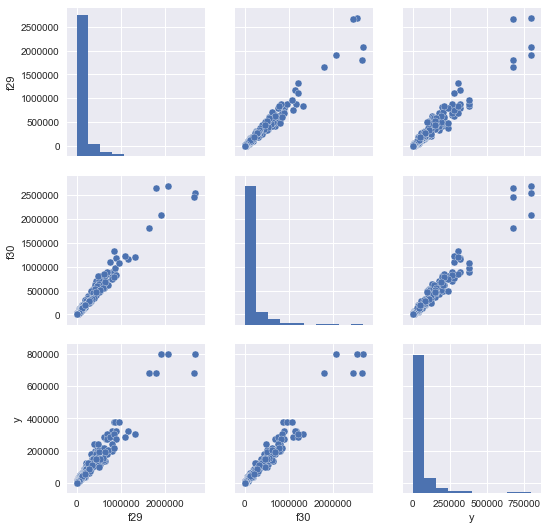

In [63]:
plt.figure()
g = sns.pairplot(train.select(lambda x:train['week'][x]==1 and train['year'][x]==2015)[['f29', 'f30', 'y']])
plt.show()

На рисунке выше представлены зависимости, например, для 1 недели 2015 года, видно, что зависимость y(f30) очень близка к линейной. Это навело меня на мысль сделать свой регрессор для каждой недели, но, когда я это реализовала, оказалось, что это не улучшает результат. Такое решение показало около 40 SMAPE в leaderboard, поэтому я отказалась от такой стратегии

Теперь внимательно посмотрим на тестовую выборку

In [65]:
test = test.drop(test.columns[35:], axis=1)
test

,Num,year,week,shift,item_id,f1,f2,f3,f4,f5,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,348622,2015,3,3,20447918,960.0,820.0,1128.0,1801.0,1045.0,...,1510.0,580.0,969.0,1635.0,895.0,2140.0,1182.0,1020.0,1293.0,1290.0
1,348623,2015,3,3,20447902,9086.0,12585.0,11595.0,9685.0,12917.0,...,22055.0,14235.0,21195.0,18280.0,18270.0,15851.0,16920.0,18320.0,24116.0,21307.0
2,348624,2015,3,3,20447732,115087.0,147287.0,176065.0,143105.0,202069.0,...,302165.0,162232.0,221622.0,256605.0,240047.0,236630.0,206697.0,245652.0,286179.0,285904.0
3,348625,2015,3,3,20443951,20900.0,24420.0,27068.0,20460.0,25580.0,...,39055.0,14445.0,22450.0,22093.0,31175.0,23355.0,15358.0,18930.0,29643.0,33970.0
4,348626,2015,3,3,20443944,4430.0,5864.0,3310.0,1853.0,2836.0,...,120.0,130.0,60.0,30.0,50.0,20.0,20.0,30.0,0.0,0.0
5,348627,2015,3,3,20443943,57289.0,80036.0,112511.0,116002.0,171900.0,...,122340.0,50368.0,94634.0,91999.0,119165.0,96190.0,88666.0,118744.0,132368.0,117730.0
6,348628,2015,3,3,20443941,21868.0,30620.0,45886.0,49732.0,75195.0,...,77370.0,40930.0,63143.0,61417.0,63957.0,43027.0,53260.0,58029.0,62126.0,71857.0
7,348629,2015,3,3,20443902,41105.0,57637.0,54540.0,68171.0,64825.0,...,102330.0,36506.0,43432.0,52948.0,57199.0,60984.0,44887.0,58033.0,98839.0,76432.0
8,348630,2015,3,3,20443901,39381.0,56933.0,59899.0,67243.0,58880.0,...,106168.0,37908.0,45296.0,53534.0,58892.0,61250.0,54951.0,62347.0,106921.0,84194.0
9,348631,2015,3,3,20443308,5922.0,16070.0,14665.0,10640.0,20150.0,...,4081.0,1660.0,1610.0,2190.0,1464.0,1720.0,20460.0,1650.0,2568.0,1902.0


Рассмотрим, например, строку 2015. В ней требуется посчитать спрос для 5 недели 2015 года, а сдвиг равен 1. Это значит, что в этой строке содержится информация о продаже данного продукта за недели 3 и 4, дня которых требуется посчитать продажи в других строках выборки. Если понять, как эту информацию извлечь, то можно схитрить и дать точные ответы на части выборки. Впосле логично предположить, что эта информация содержится в последнем признаке (за последний период наблюдения)

In [68]:
test.select(lambda x : test['item_id'][x]==20448900 and test['week'][x]-test['shift'][x]==2)

,Num,year,week,shift,item_id,f1,f2,f3,f4,f5,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
704,350217,2015,3,1,20448900,10559.0,8252.0,9000.0,12592.0,17267.0,...,3372.0,3914.0,3737.0,4361.0,4657.0,5221.0,6130.0,4177.0,1130.0,4582.0
931,350444,2015,4,2,20448900,10559.0,8252.0,9000.0,12592.0,17267.0,...,3372.0,3914.0,3737.0,4361.0,4657.0,5221.0,6130.0,4177.0,1130.0,4582.0
1154,350667,2015,5,3,20448900,10559.0,8252.0,9000.0,12592.0,17267.0,...,3372.0,3914.0,3737.0,4361.0,4657.0,5221.0,6130.0,4177.0,1130.0,4582.0


Итак, все данные совпадают, и где-то в них спряталось значение продаж объекта 20448900 за 2 неделю, предположительно, оно должно быть в f30

Исследуем это на тренировочной выборке

In [69]:
data_week = train.select(lambda x : train['week'][x]-train['shift'][x]==1)
target_week = train.select(lambda x : train['week'][x]==1)
target_week.select(lambda x : train['item_id'][x]==20441789).head()

,Num,y,year,week,shift,item_id,f1,f2,f3,f4,...,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60
246,246,14538,2013,1,2,20441789,1440.0,14601.0,12127.0,17498.0,...,13531.0,15015.0,18574.0,9146.0,14865.0,13051.0,17389.0,10739.0,13260.0,15570.0
707,3479,14538,2013,1,1,20441789,14601.0,12127.0,17498.0,22130.0,...,15015.0,18574.0,9146.0,14865.0,13051.0,17389.0,10739.0,13260.0,15570.0,22750.0
35392,174167,15761,2014,1,3,20441789,14425.0,18501.0,11319.0,8820.0,...,9879.0,10275.0,10065.0,13480.0,5350.0,10930.0,9590.0,12910.0,7015.0,9840.0
35842,177272,15761,2014,1,2,20441789,18501.0,11319.0,8820.0,13950.0,...,10275.0,10065.0,13480.0,5350.0,10930.0,9590.0,12910.0,7015.0,9840.0,13107.0
36287,180372,15761,2014,1,1,20441789,11319.0,8820.0,13950.0,12410.0,...,10065.0,13480.0,5350.0,10930.0,9590.0,12910.0,7015.0,9840.0,13107.0,15434.0


In [70]:
data_week.select(lambda x : train['item_id'][x]==20441789).head()

,Num,y,year,week,shift,item_id,f1,f2,f3,f4,...,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60
1399,6942,10674,2013,2,1,20441789,12127.0,17498.0,22130.0,13160.0,...,18574.0,9146.0,14865.0,13051.0,17389.0,10739.0,13260.0,15570.0,22750.0,9030.0
1632,7175,18403,2013,3,2,20441789,12127.0,17498.0,22130.0,13160.0,...,18574.0,9146.0,14865.0,13051.0,17389.0,10739.0,13260.0,15570.0,22750.0,9030.0
1857,7400,17291,2013,4,3,20441789,12127.0,17498.0,22130.0,13160.0,...,18574.0,9146.0,14865.0,13051.0,17389.0,10739.0,13260.0,15570.0,22750.0,9030.0
36951,183694,7937,2014,2,1,20441789,8820.0,13950.0,12410.0,11050.0,...,13480.0,5350.0,10930.0,9590.0,12910.0,7015.0,9840.0,13107.0,15434.0,9790.0
37171,183914,12654,2014,3,2,20441789,8820.0,13950.0,12410.0,11050.0,...,13480.0,5350.0,10930.0,9590.0,12910.0,7015.0,9840.0,13107.0,15434.0,9790.0


посмотрим на значения 'y' из target_week /'f30' в data_week

In [72]:
print(14538/9030, 15761/9790)

1.609966777408638 1.6099080694586312


Магия, они совпали! Итак, проверив это еще на нескольких объектах, я убедилась, что эта магическая константа и есть коэффициент пропорциональности между 'f60' и 'y'

## Итоговый алгоритм

In [ ]:
model = RandomForestRegressor(n_estimators=1000,random_state=43)
model.fit(X, y)
preds = model.predict(test.drop(['Num'], axis=1))

In [ ]:
i=0
for r in test.iterrows():
    item = r[1]['item_id']
    wk = r[1]['week']
    
    tr = test.select(lambda x: test['item_id'][x]==item and test['week'][x] - test['shift'][x] == wk)
    if(len(tr)>0):
        preds[i] = tr['f60'][tr.index[0]]*1.6099080694586312
    i+=1